In [11]:
import os
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
import cv2 
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [12]:
preTrainedModelName = "ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8"

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(os.path.join("models", preTrainedModelName, "pipeline.config"))
detection_model = model_builder.build(model_config=configs['model'], is_training=False)


# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join("models", preTrainedModelName, 'ckpt-7')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [13]:
category_index = label_map_util.create_category_index_from_labelmap('label_map.pbtxt')
IMAGE_PATH = os.path.join("dataset", 'test', '0b2bdc2d-4df2-4b86-a396-cb0325ea269b_1.jpg')

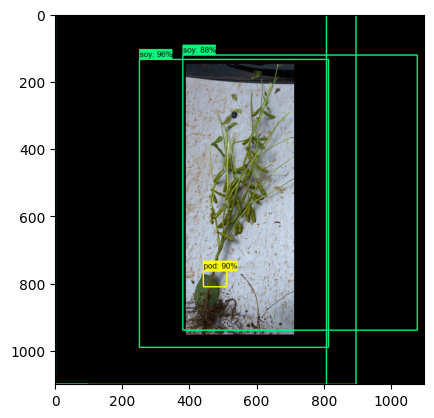

In [16]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()
